In [2]:
from fastai.vision.all import *

In [3]:
help(untar_data)

Help on function untar_data in module fastai.data.external:

untar_data(url: 'str', archive: 'Path' = None, data: 'Path' = None, c_key: 'str' = 'data', force_download: 'bool' = False, base: 'str' = '~/.fastai') -> 'Path'
    Download `url` using `FastDownload.get`



In [4]:
path = untar_data(URLs.PETS)

In [5]:
set_seed(42)

In [6]:
path.ls()[:3]

(#2) [Path('C:/Users/kevol/.fastai/data/oxford-iiit-pet/annotations'),Path('C:/Users/kevol/.fastai/data/oxford-iiit-pet/images')]

In [7]:
(path/'images').ls()[:3]

(#3) [Path('C:/Users/kevol/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),Path('C:/Users/kevol/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),Path('C:/Users/kevol/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg')]

In [8]:
path = untar_data(URLs.PETS)
fnames = get_image_files(path/'images')
pat = r'(.+)_\d+.jpg$'

In [9]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=64

In [10]:
dls = ImageDataLoaders.from_name_re(
    path, # The location of the data
    fnames, # A list of filenames
    pat, # A regex pattern to extract the labels
    item_tfms=item_tfms, # Transform augmentations to be applied per item
    batch_tfms=batch_tfms, # Transform augmentations to be applied per batch
    bs=bs # How many examples should be drawn each time
)

In [11]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [12]:
path_im = path/'images'

In [13]:
dls = pets.dataloaders(path_im, bs=bs)

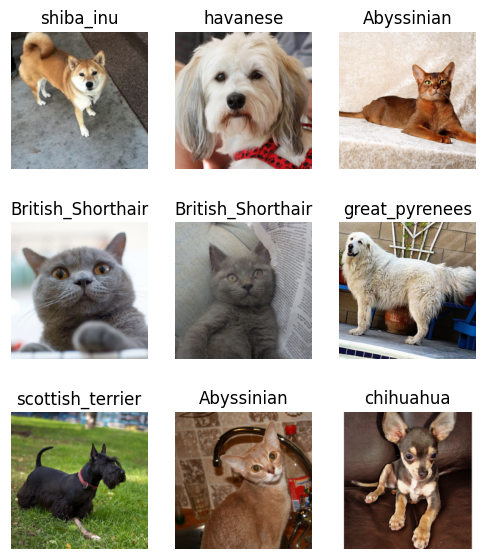

In [14]:
dls.show_batch(max_n=9, figsize=(6,7))

In [15]:
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [16]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

In [17]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.885627,0.327834,0.106225,01:55
1,0.684137,0.219920,0.070365,01:16
2,0.393668,0.195898,0.067659,01:14
3,0.290944,0.186789,0.066306,01:14


In [18]:
learn.save('stage_1')

Path('models/stage_1.pth')

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

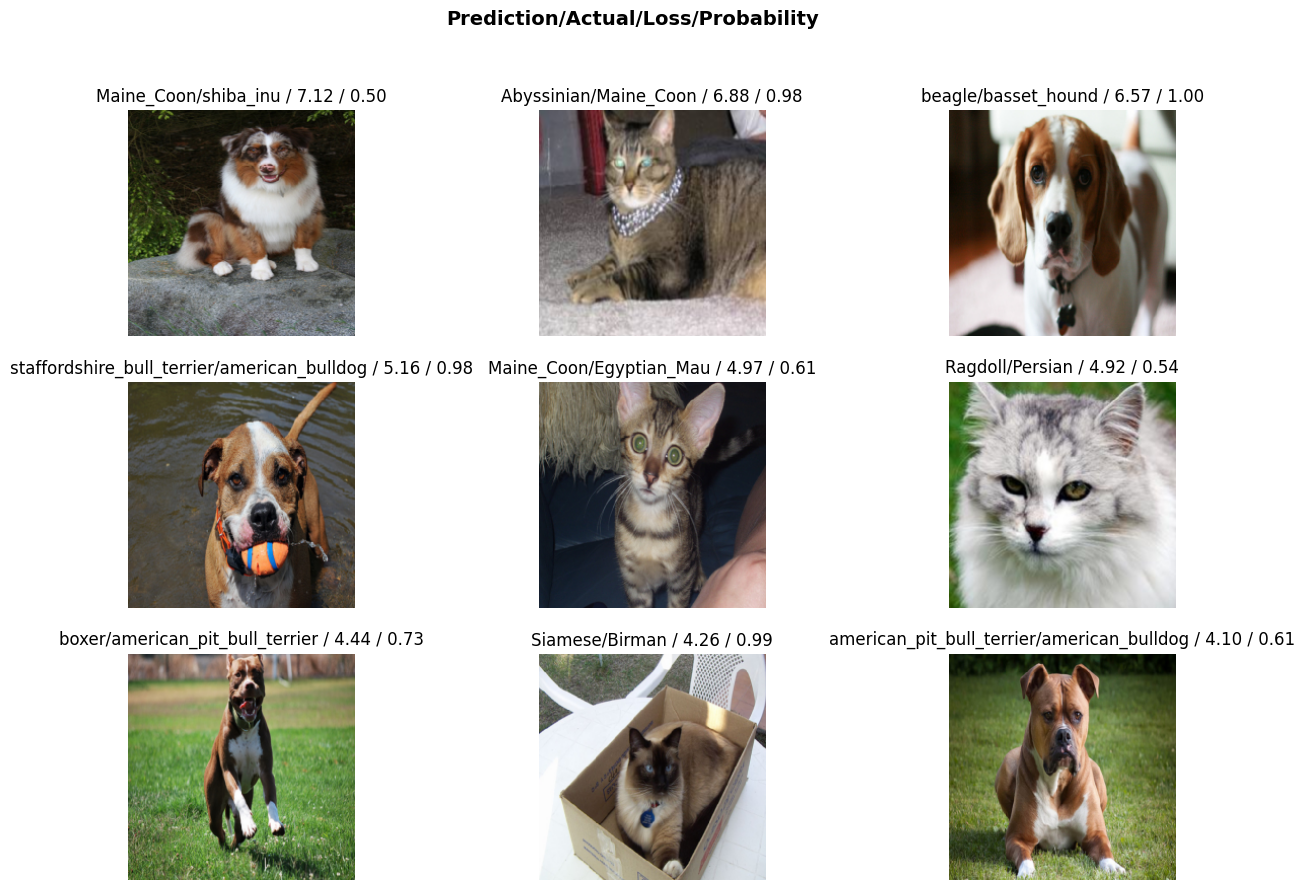

In [20]:
interp.plot_top_losses(9, figsize=(15,10))

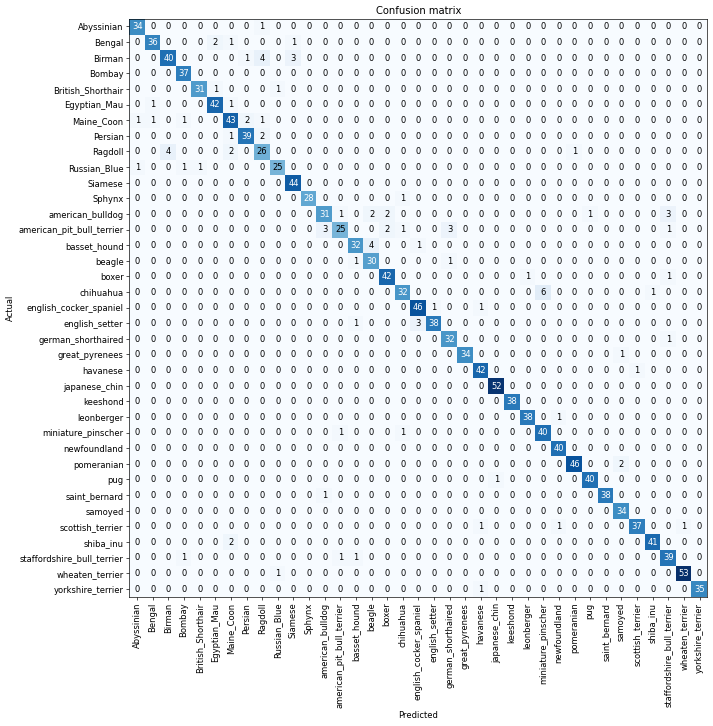

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
interp.most_confused(min_val=3)

[('chihuahua', 'miniature_pinscher', 6),
 ('Birman', 'Ragdoll', 4),
 ('Ragdoll', 'Birman', 4),
 ('basset_hound', 'beagle', 4),
 ('Birman', 'Siamese', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('american_pit_bull_terrier', 'german_shorthaired', 3),
 ('english_setter', 'english_cocker_spaniel', 3)]

SuggestedLRs(valley=8.31763736641733e-06)

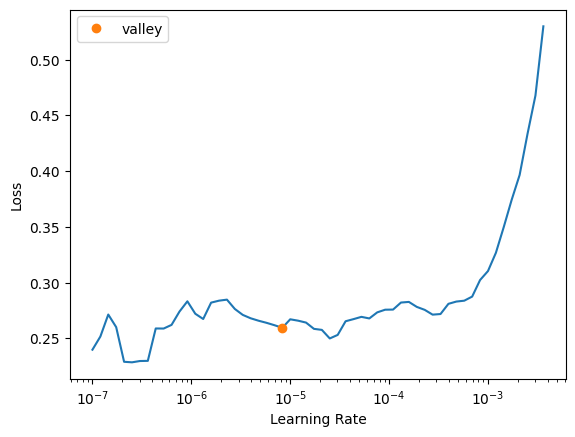

In [23]:
learn.load('stage_1')
learn.unfreeze()
learn.lr_find()

In [24]:
learn.fit_one_cycle(4, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.273334,0.184638,0.060893,01:30
1,0.238570,0.175594,0.060217,01:35
2,0.214304,0.173573,0.060893,01:32
3,0.190848,0.167774,0.056157,01:31


In [25]:
learn.save('stage_2')

Path('models/stage_2.pth')

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

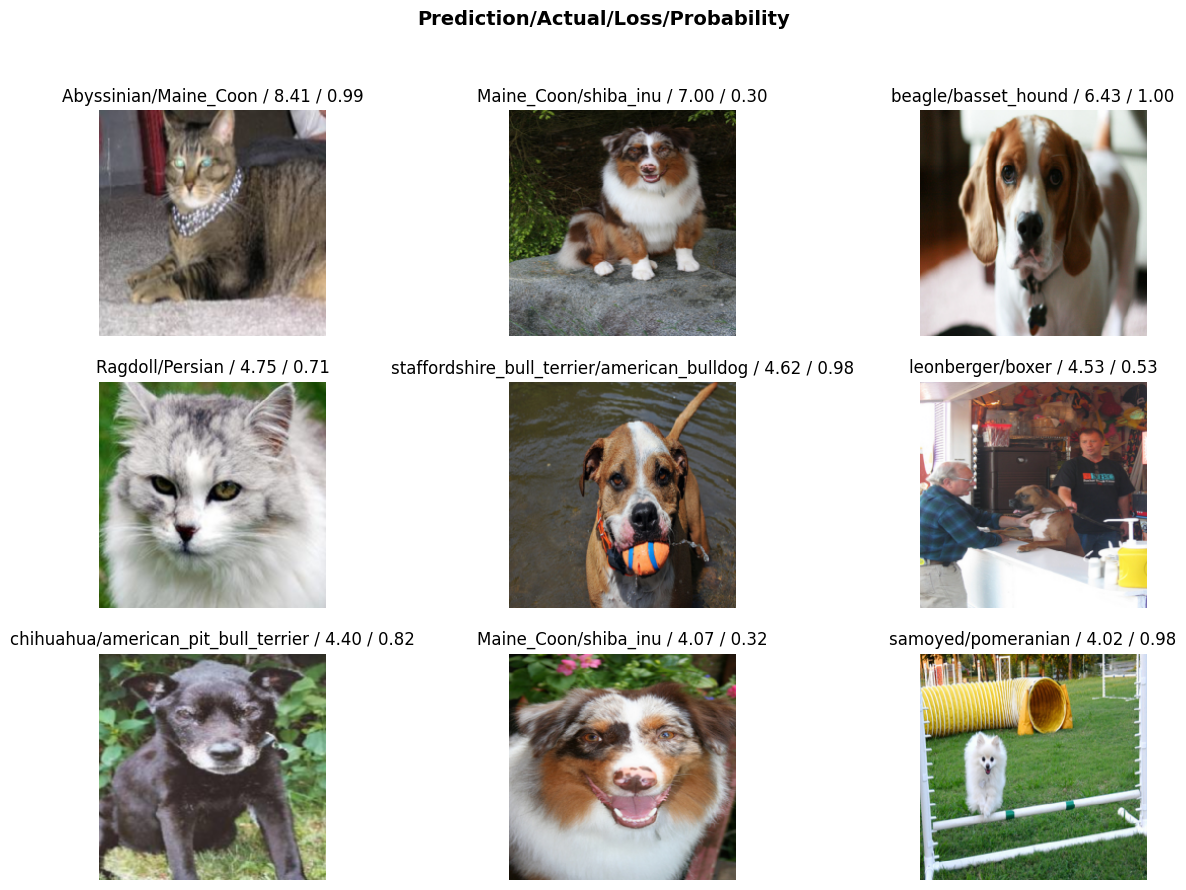

In [27]:
interp.plot_top_losses(9, figsize=(15,10))

In [28]:
interp.most_confused(min_val=3)

[('Bengal', 'Egyptian_Mau', 4),
 ('Birman', 'Ragdoll', 4),
 ('Birman', 'Siamese', 4),
 ('Ragdoll', 'Birman', 4),
 ('american_bulldog', 'boxer', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('basset_hound', 'beagle', 3)]